# XGBoost Classification Solutions

![Namespace Labs](../../../../labs.png)

pip install xgboost

## Churn Prediction

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [66]:
# Read in churn.csv
df = pd.read_csv("churn.csv")

In [67]:
# check the head of the loaded dataframe
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


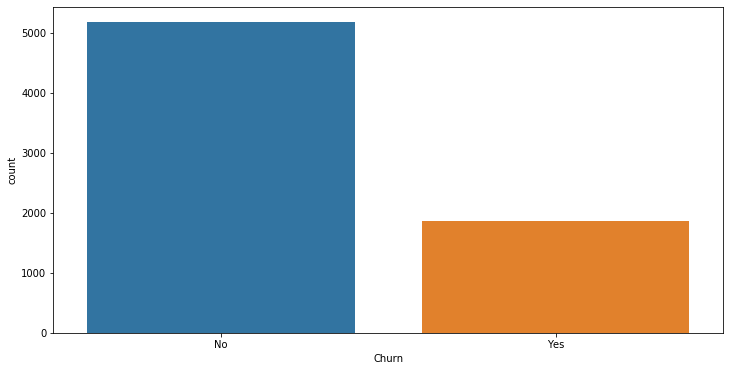

In [68]:
# Plot the graph below
plt.figure(figsize=(12,6))

sns.countplot(x='Churn',data=df)

In [69]:
# Create a dataframe called cat_feats
# It should contain all the categorical features of the 
# Data Frame
cat_feats = ['Partner','gender','SeniorCitizen','Dependents','PhoneService','MultipleLines',
             'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod' ]

In [70]:
# Convert Churn into a dummy variable
df = pd.get_dummies(df,columns = ['Churn'],drop_first=True)

In [71]:
# Convert the categories into integers
# Display the head of the converted dataframe
from category_encoders import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(cols=cat_feats, handle_missing='return_nan')

df = ordinal_encoder.fit_transform(df)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_Yes
0,7590-VHVEG,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.85,29.85,0
1,5575-GNVDE,2.0,1.0,2.0,1.0,34,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,1.0,2.0,2.0,2.0,56.95,1889.50,0
2,3668-QPYBK,2.0,1.0,2.0,1.0,2,2.0,2.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,53.85,108.15,1
3,7795-CFOCW,2.0,1.0,2.0,1.0,45,1.0,1.0,1.0,2.0,...,2.0,2.0,1.0,1.0,2.0,2.0,3.0,42.30,1840.75,0
4,9237-HQITU,1.0,1.0,2.0,1.0,2,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,70.70,151.65,1


In [72]:
labels = df['Churn_Yes']

In [73]:
# Create the X variable
df = df.drop(['customerID','Churn_Yes'],axis=1)

In [74]:
# Create the y variable
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.85,29.85
1,2.0,1.0,2.0,1.0,34,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,56.95,1889.50
2,2.0,1.0,2.0,1.0,2,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,53.85,108.15
3,2.0,1.0,2.0,1.0,45,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,42.30,1840.75
4,1.0,1.0,2.0,1.0,2,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,70.70,151.65


In [77]:
categoricals = [df.columns.get_loc(i) for i in cat_feats]

In [76]:
label=['Churn']

In [75]:
labels.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn_Yes, dtype: uint8

In [48]:
# Split the data into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

In [78]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 10),
        'seed': 0
    }

In [80]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
np.random.seed(0)
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool
from catboost import CatBoostClassifier 
from hyperopt import fmin, hp, tpe
from sklearn.metrics import accuracy_score

In [101]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [102]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


SCORE:                                                 
0.7292948414576431                                     
SCORE:                                                                            
0.7292948414576431                                                                
SCORE:                                                                            
0.7543776620918126                                                                
SCORE:                                                                            
0.7292948414576431                                                                
SCORE:                                                                            
0.7292948414576431                                                                
SCORE:                                                                            
0.7813535257927118                                                                
SCORE:                                                    

SCORE:                                                                             
0.7737813535257927                                                                 
SCORE:                                                                             
0.7799337434926644                                                                 
SCORE:                                                                             
0.7524846190250828                                                                 
SCORE:                                                                             
0.7799337434926644                                                                 
SCORE:                                                                             
0.780407004259347                                                                  
SCORE:                                                                             
0.7292948414576431                                                          

0.7292948414576431                                                                 
SCORE:                                                                             
0.7576904874585897                                                                 
SCORE:                                                                             
0.7292948414576431                                                                 
100%|██████████| 100/100 [00:57<00:00,  1.73trial/s, best loss: -0.7851396119261713]


In [103]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9653546664381807, 'gamma': 5.256602839802326, 'max_depth': 18.0, 'min_child_weight': 8.0, 'n_estimators': 70.0, 'reg_alpha': 40.0, 'reg_lambda': 0.5707756678259518}


In [104]:
# Import XGBClassifier
from xgboost import XGBClassifier

In [116]:
# Create an instance of XGBClassifier
model = XGBClassifier(colsample_bytree= 0.9653546664381807, gamma= 5.256602839802326, max_depth= 18, min_child_weight= 8, n_estimators= 70, reg_alpha= 40.0, reg_lambda= 0.5707756678259518)

In [117]:
# Fit the data to the training set
model.fit(X_train,y_train)    

[13:12:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9653546664381807,
              gamma=5.256602839802326, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=18, min_child_weight=8, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=40.0, reg_lambda=0.5707756678259518, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [118]:
# Make predctions
# Store the predictions in a variable
predictions = model.predict(X_test)

In [119]:
# import the common classification metrics
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [120]:
# Check the model's accuracy
accuracy_score(predictions, y_test)

0.791292001893043

In [121]:
# Print the confusion Matrix
confusion_matrix(predictions, y_test)

array([[1408,  308],
       [ 133,  264]], dtype=int64)

In [122]:
# Plot the confussion matrix
from sklearn.metrics import plot_confusion_matrix

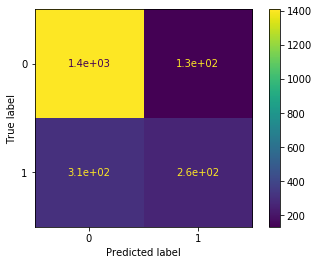

In [123]:
plot_confusion_matrix(model,X_test,y_test)

In [124]:
# Print the classification report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1716
           1       0.46      0.66      0.54       397

    accuracy                           0.79      2113
   macro avg       0.69      0.74      0.70      2113
weighted avg       0.83      0.79      0.80      2113



Happy Coding!